In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
pd.set_option('display.max_columns', 200)

# City Data Cleaning

In [6]:
Austin_data = pd.read_csv('datasets/Austin_listings.csv')
Boston_data = pd.read_csv('datasets/Boston_listings.csv')
Chicago_data = pd.read_csv('datasets/Chicago_listings.csv')
Denver_data = pd.read_csv('datasets/Denver_listings.csv')
Austin_data['cityREAL'] = 'Austin'
Austin_data['state'] = 'TX'
Boston_data['cityREAL'] = 'Boston'
Boston_data['state'] = 'MA'
Chicago_data['cityREAL'] = 'Chicago'
Chicago_data['state'] = 'IL'
Denver_data['cityREAL'] = 'Denver'
Denver_data['state'] = 'CO'
cols_to_keep =['id', 'cityREAL', 'state', 'host_is_superhost', 'neighbourhood', 'zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'review_scores_rating', 'number_of_reviews', 'square_feet', 'minimum_nights', 'price']

In [7]:
Austin_data = Austin_data[cols_to_keep]
Boston_data = Boston_data[cols_to_keep]
Chicago_data = Chicago_data[cols_to_keep]
Denver_data = Denver_data[cols_to_keep]

In [8]:
city_data = pd.concat([Austin_data,Boston_data, Chicago_data, Denver_data])
city_data = city_data.rename(index=str, columns={'cityREAL':'city', 'host_is_superhost': 'is superhost', 'property_type':'property type', 'room_type':'room type', 'bed_type':'bed type', 'review_scores_rating':'review score', 'number_of_reviews':'num reviews', 'square_feet':'square ft', 'minimum_nights':'min nights'})


In [9]:
Zillow_data = pd.read_csv('datasets/Zillow_ZHVI.csv', encoding='latin-1')
Zillow_data = Zillow_data[['RegionName','City', 'State', 'Zhvi']]
Zillow_data = Zillow_data.rename(index=str, columns={'RegionName':'Zipcode'})

In [10]:
def get_property(prop):
    prop = prop.lower()
    if prop in ['bungalow', 'cabin', 'chalet', 'townhouse', 'cottage', 'dome house', 'earth house', 'tiny house', 'villa', 'house']:
        return 'House'
    elif prop in ['serviced apartment', 'loft', 'apartment']:
        return 'Apartment'
    elif prop in ['aparthotel', 'boutique hotel', 'hotel', 'hostel', 'resort']:
        return 'Hotel'
    elif prop in ['condominium']:
        return 'Condo'
    elif prop in ['guesthouse', 'guest suite']:
        return 'Guest'
    else:
        return 'Other'

In [11]:
city_data = city_data.drop(['square ft'],axis=1)
city_data_w_neighbordhood = city_data.copy()
city_data = city_data.drop(['min nights'], axis=1)
city_data = city_data.dropna(subset=['city', 'zipcode', 'bathrooms', 'bedrooms', 'beds','is superhost'])
city_data['price'] = city_data['price'].map(lambda x: float(x.lstrip('$').replace(',','')))
city_data = city_data[city_data.price > 10.0]
city_data = city_data[city_data.price < 2000.0]
city_data['logprice'] = city_data['price'].map(lambda x: np.log(x))
city_data['is superhost'] = city_data['is superhost'].map(lambda x: int(x == 't'))
city_data['property type'] = city_data['property type'].map(lambda x: get_property(x))

In [12]:
city_data_room = pd.get_dummies(city_data['room type']) 
city_data = pd.concat([city_data.reset_index(drop=True),city_data_room.reset_index(drop=True)], axis=1)
#city_data = city_data.drop('room type', axis=1)

city_data_bed = pd.get_dummies(city_data['bed type']) 
city_data = pd.concat([city_data.reset_index(drop=True),city_data_bed.reset_index(drop=True)], axis=1)
#city_data = city_data.drop('bed type', axis=1)

city_data_prop = pd.get_dummies(city_data['property type']) 
city_data = pd.concat([city_data.reset_index(drop=True),city_data_prop.reset_index(drop=True)], axis=1)
#city_data = city_data.drop('property type', axis=1)

In [13]:
def find_Zhvi(x):
    Zipcode = x['zipcode']
    City = x['city']
    State = x['state']
    zipD = Zillow_data[Zillow_data['Zipcode'] == Zipcode]
    ans = zipD['Zhvi'].mean()
    
    if ans > 0:
        return ans
    else:
        cityD = Zillow_data[Zillow_data['City'] == City]
        ans = cityD['Zhvi'].mean()
    
        if ans > 0:
            return ans
        else:
            stateD = Zillow_data[Zillow_data['State'] == State]
            ans = stateD['Zhvi'].mean()
        
            if ans > 0:
                return ans
            else:
                return Zillow_data['Zhvi'].mean()

In [14]:
city_data['Zhvi'] = city_data.apply(find_Zhvi, axis=1)

In [15]:
from sklearn import preprocessing

x = city_data[['Zhvi']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
NZ = pd.DataFrame(x_scaled)

city_data = pd.concat([city_data.reset_index(drop=True),NZ.reset_index(drop=True)], axis=1)
city_data = city_data.rename(index=str, columns={0:'Normalized Zhvi'})

city_data['Log Zhvi'] = city_data['Zhvi'].map(lambda x: np.log(x))

In [16]:
amset = set()
for i in range(30199):
    ams = city_data['amenities'][i]
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    amset.update(amslist)

amdict = {}
for am in amset:
    if am != '':
        amdict[am] = 0

for i in range(30199):
    ams = city_data['amenities'][i]
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    for am in amslist:
        if am != '':
            amdict[am] += 1

import operator
sorted_am = sorted(amdict.items(), key=operator.itemgetter(1))
top20 = sorted_am[-20::]
top20.reverse()
print(top20)

[('Wifi', 29436), ('Heating', 29252), ('Essentials', 28802), ('Smoke detector', 28234), ('Kitchen', 28070), ('Air conditioning', 27566), ('Hangers', 25224), ('Shampoo', 25200), ('TV', 25091), ('Washer', 23775), ('Dryer', 23668), ('Carbon monoxide detector', 23437), ('Hair dryer', 23236), ('Laptop friendly workspace', 22956), ('Iron', 22905), ('Fire extinguisher', 19649), ('Hot water', 18576), ('Free parking on premises', 15622), ('Self check-in', 14547), ('First aid kit', 13401)]


In [17]:
def has_wifi(x):
    f = 'Wifi'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_heat(x):
    f = 'Heating'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_essent(x):
    f = 'Essentials'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_smoke(x):
    f = 'Smoke detector'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_kitchen(x):
    f = 'Kitchen'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_air(x):
    f = 'Air conditioning'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)
    
def has_hangers(x):
    f = 'Hangers'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_shampoo(x):
    f = 'Shampoo'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_tv(x):
    f = 'TV'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_washer(x):
    f = 'Washer'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_dryer(x):
    f = 'Dryer'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_co2(x):
    f = 'Carbon Monoxide Detector'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_hair(x):
    f = 'Hair Dryer'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_laptop(x):
    f = 'Laptop friendly workspace'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_iron(x):
    f = 'Iron'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_fire(x):
    f = 'Fire extinguisher'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)
    
def has_water(x):
    f = 'Hot water'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_parking(x):
    f = 'Free parking on premises'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_check(x):
    f = 'Self check-in'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

def has_aid(x):
    f = 'First aid kit'
    ams = x['amenities']
    ams = ams.lstrip('{').rstrip('}').replace('"','')
    amslist = ams.split(',')
    return int(f in amslist)

In [18]:
city_data['Wifi'] = city_data.apply(has_wifi, axis=1)
city_data['Heat'] = city_data.apply(has_heat, axis=1)
city_data['Essentials'] = city_data.apply(has_essent, axis=1)
city_data['Smoke Detector'] = city_data.apply(has_smoke, axis=1)
city_data['Kitchen'] = city_data.apply(has_kitchen, axis=1)
city_data['Air Conditioning'] = city_data.apply(has_air, axis=1)
city_data['Hangers'] = city_data.apply(has_hangers, axis=1)
city_data['Shampoo'] = city_data.apply(has_shampoo, axis=1)
city_data['TV'] = city_data.apply(has_tv, axis=1)
city_data['Washer'] = city_data.apply(has_washer, axis=1)
city_data['Dryer'] = city_data.apply(has_dryer, axis=1)
city_data['Carbon Monoxide Detector'] = city_data.apply(has_co2, axis=1)
city_data['Hair Dryer'] = city_data.apply(has_hair, axis=1)
city_data['Laptop Friendly Workspace'] = city_data.apply(has_laptop, axis=1)
city_data['Iron'] = city_data.apply(has_iron, axis=1)
city_data['Fire Extinguisher'] = city_data.apply(has_fire, axis=1)
city_data['Hot Water'] = city_data.apply(has_water, axis=1)
city_data['Free Parking on Premises'] = city_data.apply(has_parking, axis=1)
city_data['Self Check-in'] = city_data.apply(has_check, axis=1)
city_data['First Aid Kit'] = city_data.apply(has_aid, axis=1)

In [19]:
import math
def get_interval(x):
    r_score = x['review score']
    num_r = x['num reviews']
    if num_r == 0:
        return 83.034659
    if np.isnan(r_score):
        return 83.034659
        
    p_hat = r_score/100
    upper_b = (p_hat+((1.96**2)/(2 * num_r))+(1.96*math.sqrt(((p_hat * (1-p_hat)) + ((1.96**2)/(4*num_r)))/num_r)))/(1+((1.96**2)/num_r))
    lower_b = (p_hat+((1.96**2)/(2 * num_r))-(1.96*math.sqrt(((p_hat * (1-p_hat)) + ((1.96**2)/(4*num_r)))/num_r)))/(1+((1.96**2)/num_r))
    mean = (upper_b + lower_b)/2
    return mean * 100
               

In [20]:
city_data['review conf'] = city_data.apply(get_interval, axis=1)


(array([2.000e+00, 0.000e+00, 4.000e+01, 2.100e+01, 8.300e+01, 5.000e+01,
        3.130e+02, 1.867e+03, 3.440e+02, 1.325e+03, 4.660e+02, 1.327e+03,
        1.227e+03, 1.666e+03, 7.623e+03, 2.269e+03, 2.588e+03, 3.399e+03,
        3.968e+03, 1.621e+03]),
 array([36.84518241, 39.98430517, 43.12342794, 46.2625507 , 49.40167346,
        52.54079622, 55.67991898, 58.81904174, 61.9581645 , 65.09728726,
        68.23641002, 71.37553278, 74.51465554, 77.65377831, 80.79290107,
        83.93202383, 87.07114659, 90.21026935, 93.34939211, 96.48851487,
        99.62763763]),
 <a list of 20 Patch objects>)

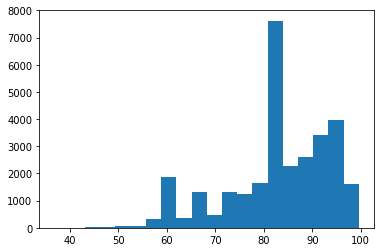

In [21]:
plt.hist(city_data['review conf'], bins=20)

In [22]:
city_data_csv = city_data.to_csv('clean_city_data.csv', header=True)

In [25]:
city_data.head()

,id,city,state,is superhost,neighbourhood,zipcode,latitude,longitude,property type,room type,accommodates,bathrooms,bedrooms,beds,bed type,amenities,review score,num reviews,price,logprice,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Apartment,Condo,Guest,Hotel,House,Other,Zhvi,Normalized Zhvi,Log Zhvi,Wifi,Heat,Essentials,Smoke Detector,Kitchen,Air Conditioning,Hangers,Shampoo,TV,Washer,Dryer,Carbon Monoxide Detector,Hair Dryer,Laptop Friendly Workspace,Iron,Fire Extinguisher,Hot Water,Free Parking on Premises,Self Check-in,First Aid Kit,review conf
0,1078,Austin,TX,1,University of Texas,78705,30.30123,-97.73674,Guest,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",98.0,208,85.0,4.442651,1,0,0,0,0,0,0,1,0,0,1,0,0,0,274200.0,0.099071,12.521613,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,0,0,1,1,0,97.129553
1,2265,Austin,TX,1,East Downtown,78702,30.27750,-97.71398,House,Entire home/apt,4,2.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",93.0,23,225.0,5.416100,1,0,0,0,0,0,0,1,0,0,0,0,1,0,431500.0,0.304934,12.975023,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1,0,86.845792
2,5245,Austin,TX,1,East Downtown,78702,30.27577,-97.71379,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",91.0,9,100.0,4.605170,0,1,0,0,0,0,0,1,0,0,0,0,1,0,431500.0,0.304934,12.975023,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,0,78.734737
3,5456,Austin,TX,1,East Downtown,78702,30.26112,-97.73448,Guest,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets live...",96.0,472,95.0,4.553877,1,0,0,0,0,0,0,1,0,0,1,0,0,0,431500.0,0.304934,12.975023,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,95.628629
4,5769,Austin,TX,1,SW Williamson Co.,78729,30.45596,-97.78370,House,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",98.0,240,40.0,3.688879,0,1,0,0,0,0,0,1,0,0,0,0,1,0,298200.0,0.130480,12.605520,1,1,1,1,1,1,0,1,1,0,1,0,0,0,0,1,1,1,0,1,97.243784
